# Organic Carbon Content Prediction

In [1]:
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.neighbors.kde import KernelDensity
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, ElasticNetCV, ElasticNet
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
# Directory of the Data
data = "C:/Users/danie/Documents/EPFL MA1/Fall 1/Machine Learning/Carbon Analysis Project/data"

In [3]:
df_meas = pd.read_csv(data + "/IMPROVE_2015_measures_cs433.csv")
df_spec = pd.read_csv(data + "/IMPROVE_2015_raw_spectra_cs433.csv")
df_split = pd.read_csv(data + "/IMPROVE_2015_train_test_split_cs433.csv")
df_derive = pd.read_csv(data + "/IMPROVE_2015_2nd-derivative_spectra_cs433.csv")

## Raw Data Train and Test

In [4]:
df_meas = df_meas.set_index("site")
df_OC = pd.DataFrame(df_meas[["OCf:Value","OCf:Unc"]])
df_spec = df_spec.T
"""Align spectra with measurements"""
#merge OC,OC unc and Spectra
pd_merged_OC_spec = df_OC.merge(df_spec, right_index=True, left_index=True)
#drop last column and set site as index
df_split = df_split.set_index("site", drop=True).drop(["Unnamed: 0"], axis=1) 
#merge with split 
pd_merged_OC_spec_split = pd_merged_OC_spec.merge(df_split, right_index=True, left_index=True)
 #don't need it anymore
del pd_merged_OC_spec

In [5]:
"""Set training and test data"""
set_train = pd_merged_OC_spec_split[pd_merged_OC_spec_split["usage"] == "calibration"]
set_test = pd_merged_OC_spec_split[pd_merged_OC_spec_split["usage"] == "test"]


In [6]:
"""Uncertainty Variables"""
df_OCU_tr = set_train["OCf:Unc"]
df_OCU_te = set_test["OCf:Unc"]
""" Training and test Variables"""
y_tr = set_train["OCf:Value"]
y_te = set_test["OCf:Value"]
x_tr = set_train.drop(["OCf:Value","OCf:Unc","usage"], axis=1)
x_te = set_test.drop(["OCf:Value","OCf:Unc","usage"], axis=1)



In [7]:
x_tr.head()

,0,1,2,3,4,5,6,7,8,9,...,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783
CRLA1_04_21_2015_NM_0_csv,0.99057,0.99010,0.98964,0.98917,0.98869,0.98822,0.98776,0.98731,0.98685,0.98640,...,-0.137450,-0.137830,-0.138150,-0.138390,-0.138530,-0.138560,-0.138480,-0.138240,-0.137840,-0.137270
TONT1_05_09_2015_NM_0_csv,0.31219,0.31199,0.31178,0.31157,0.31137,0.31116,0.31096,0.31075,0.31055,0.31034,...,-0.063570,-0.063091,-0.062506,-0.061798,-0.060950,-0.059964,-0.058836,-0.057547,-0.056065,-0.054372
BADL1_11_26_2015_NM_0_csv,0.58565,0.58535,0.58505,0.58475,0.58446,0.58417,0.58389,0.58361,0.58332,0.58303,...,-0.099381,-0.098669,-0.097782,-0.096701,-0.095394,-0.093851,-0.092053,-0.089964,-0.087558,-0.084833
BRID1_10_27_2015_NM_0_csv,0.63373,0.63343,0.63314,0.63284,0.63253,0.63223,0.63192,0.63163,0.63133,0.63102,...,-0.102270,-0.101440,-0.100430,-0.099210,-0.097748,-0.096049,-0.094104,-0.091885,-0.089359,-0.086516
SEQU1_04_03_2015_NM_0_csv,0.51053,0.51023,0.50994,0.50964,0.50935,0.50905,0.50875,0.50846,0.50816,0.50786,...,-0.102490,-0.102690,-0.102870,-0.103020,-0.103120,-0.103160,-0.103110,-0.102930,-0.102600,-0.102110


## 2nd Derivative Train and Test 

In [8]:
df_derive = df_derive.T
pd_merged_der_OC_spec = df_OC.merge(df_derive, right_index=True, left_index=True)
pd_merged_der_OC_spec_split = pd_merged_der_OC_spec.merge(df_split, right_index=True, left_index=True)
set_train_der = pd_merged_der_OC_spec_split[pd_merged_der_OC_spec_split["usage"] == "calibration"]
set_test_der = pd_merged_der_OC_spec_split[pd_merged_der_OC_spec_split["usage"] == "test"]



In [9]:
y_tr_der = set_train_der["OCf:Value"]
y_te_der = set_test_der["OCf:Value"]
x_tr_der = set_train_der.drop(["OCf:Value","OCf:Unc","usage"], axis=1)
x_te_der = set_test_der.drop(["OCf:Value","OCf:Unc","usage"], axis=1)

In [10]:
x_tr_der.head()

,0,1,2,3,4,5,6,7,8,9,...,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783
CRLA1_04_21_2015_NM_0_csv,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,...,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076
TONT1_05_09_2015_NM_0_csv,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
BADL1_11_26_2015_NM_0_csv,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,...,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160
BRID1_10_27_2015_NM_0_csv,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,...,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170
SEQU1_04_03_2015_NM_0_csv,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,...,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047


In [11]:
wave_no = df_spec.T['wavenumber'] # get wavenumbers

In [12]:
del set_test #Delete variables that will not be used afterwards
del pd_merged_OC_spec_split
del pd_merged_der_OC_spec
del set_test_der 

## Field Blank Extraction

In [13]:
""" Returns indexes of spectra that contain a specific label"""
def index_flag(x,label):
    x = x.values
    
    Comp =[]
    
    for Sample_ID in x:
        splits = Sample_ID.split('_')
        if len(splits)>4:
            flag = splits[4]
        else:
            flag = 'NM'
        Comp.append(flag==label)
    return Comp

In [14]:
idx_FB = index_flag(df_spec.index,'FB')
FBs = df_spec[idx_FB]
idx_FB_der = index_flag(df_derive.index,'FB')
FBs_der = df_derive[idx_FB_der]

## Raw Data FBs 

The number of Field Blanks is 463


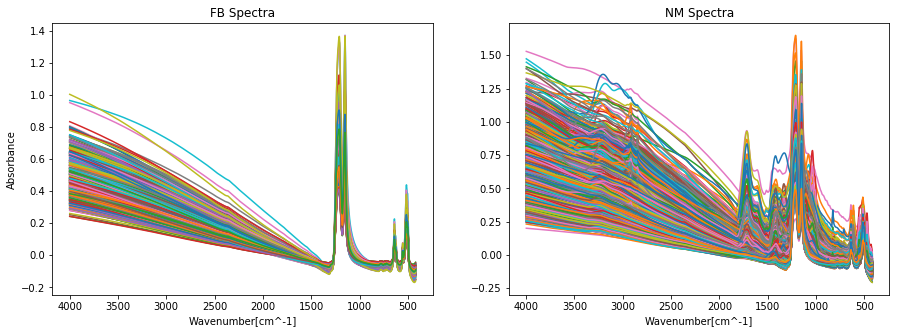

In [439]:
fig1 = plt.figure(figsize=(15,5))
ax1 = fig1.add_subplot(1,2,1)
ax1.plot(wave_no,FBs.T)
ax1.invert_xaxis()
ax1.set_xlabel('Wavenumber[cm^-1]')
ax1.set_ylabel('Absorbance')
ax1.set_title('FB Spectra')
ax2 = fig1.add_subplot(1,2,2)
ax2.plot(wave_no,x_tr.T)
ax2.set_xlabel('Wavenumber[cm^-1]')
ax2.invert_xaxis()
ax2.set_title('NM Spectra')
print('The number of Field Blanks is',np.shape(FBs_der)[0])

We see that some regions have a low variance in the FB such as in the 1200, or between 700 and 1000. These regions on the other hand have a large variance in the NM samples. The variance is also increasing with the wavenumber on the FB spectra. This is due to scattering of light of the filters.

## 2nd Derivative FB

The number of Field Blanks is 463


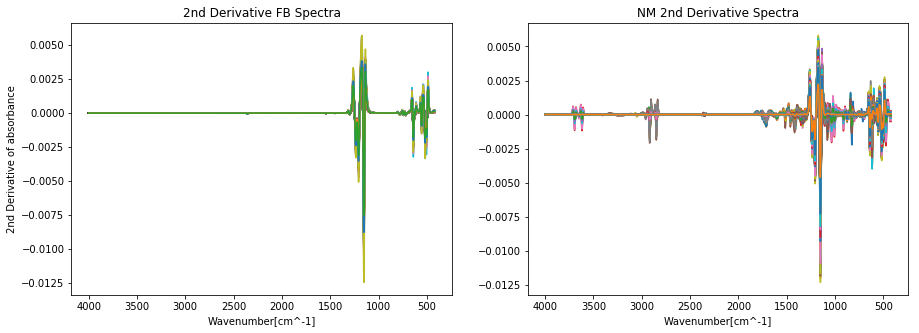

In [440]:
fig2 = plt.figure(figsize=(15,5))
ax1 = fig2.add_subplot(1,2,1)
ax1.plot(wave_no,FBs_der.T)
ax1.invert_xaxis()
ax1.set_xlabel('Wavenumber[cm^-1]')
ax1.set_ylabel('2nd Derivative of absorbance')
ax1.set_title('2nd Derivative FB Spectra')
ax2 = fig2.add_subplot(1,2,2)
ax2.plot(wave_no,x_tr_der.T)
ax2.set_xlabel('Wavenumber[cm^-1]')
ax2.invert_xaxis()
ax2.set_title('NM 2nd Derivative Spectra')
print('The number of Field Blanks is',np.shape(FBs_der)[0])

Here we see that the 2nd derivative did a good job at removing the scattering. However, we still have variance around the Teflon peak and in the fingerprint region. We can see that there are some regions that are completely flat. We can try to remove these features to save computational power

# Remove zero-features from derivative data

In [15]:

mean_der_spec=np.mean(abs(x_tr_der)) #compute the mean of the abs value of all samples
imp_feat = np.argwhere((mean_der_spec)>1e-6) #only take features whose average is higher than 1e-6
imp_feat #these are the non-zero features

array([[  64],
       [  65],
       [  66],
       ...,
       [2781],
       [2782],
       [2783]], dtype=int64)

In [16]:
x_tr_der_filtered = x_tr_der.iloc[:,imp_feat.flatten()] 
x_te_der_filtered = x_te_der.iloc[:,imp_feat.flatten()]
x_tr_der_compare = np.zeros((2784,))
x_tr_der_compare[imp_feat.flatten()] = mean_der_spec[imp_feat.flatten()]

The number of important features is 2126


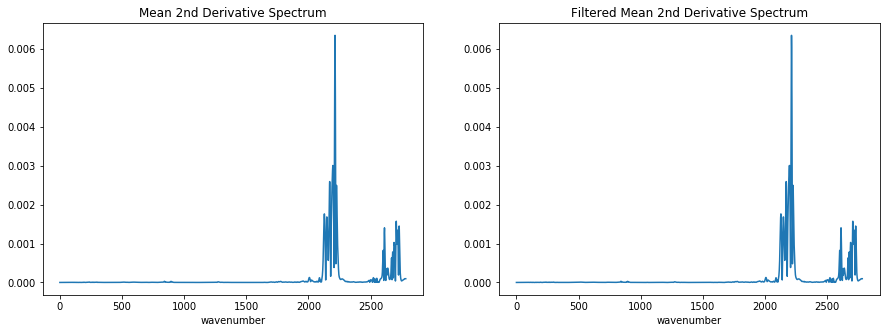

In [443]:
fig = plt.figure(figsize=(15,5))  # create a figure object
ax1 = fig.add_subplot(1, 2, 1)  # create an axes object in the figure
ax1.plot(np.arange(2784),mean_der_spec)
ax1.set_xlabel('wavenumber')
ax1.set_title('Mean 2nd Derivative Spectrum')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(np.arange(2784),x_tr_der_compare)
ax2.set_xlabel('wavenumber')
ax2.set_title('Filtered Mean 2nd Derivative Spectrum')

print('The number of important features is',np.shape(x_tr_der_filtered)[1])


In [444]:
"""Compared filtered Data using linear regression as a first step"""
lr = LinearRegression()
lr.fit(x_tr_der_filtered,y_tr)
y_pred_der_filtered = lr.predict(x_tr_der_filtered)

lr2 = LinearRegression()
lr2.fit(x_tr_der,y_tr)
y_pred_der = lr2.predict(x_tr_der)

The r2 score of the full spectra is  0.9938977307958035
The r2 score of the filtered spectra is  0.9933245988845346


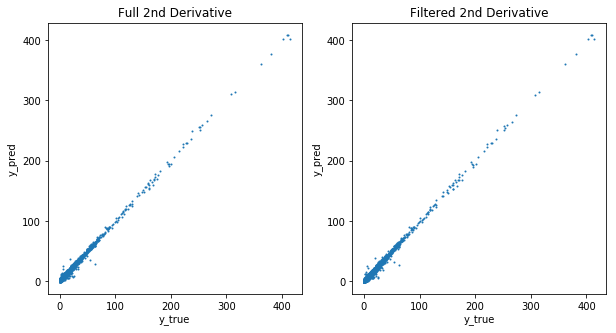

In [445]:
fig2 = plt.figure(figsize=(10,5))
ax1 = fig2.add_subplot(1,2,1)
ax1.scatter(y_tr,y_pred_der, s=1)
ax1.set_title('Full 2nd Derivative')
ax1.set_xlabel('y_true')
ax1.set_ylabel('y_pred')
ax2 = fig2.add_subplot(1,2,2)
ax2.scatter(y_tr,y_pred_der_filtered, s=1)
ax2.set_title('Filtered 2nd Derivative')
ax2.set_xlabel('y_true')
ax2.set_ylabel('y_pred')
print('The r2 score of the full spectra is ',r2_score(y_tr,y_pred_der))
print('The r2 score of the filtered spectra is ',r2_score(y_tr,y_pred_der_filtered))

We see that the linear regression does not change by much, and so we can remove the computational cost of ~700 features. 

# Alternative Smoothing Strategies: PCA
We can also extract the features that have the largest variance in the training set. Before doing so, we can remove the features that have the highest variance in the FB since these represent noise. After doing so we can get the principal components of the set. 

## Remove High variance from FB
In order to obtain the samples with highest variance in the FB we must standardize the data and then extract the largest variance

Text(0, 0.5, 'Variance')

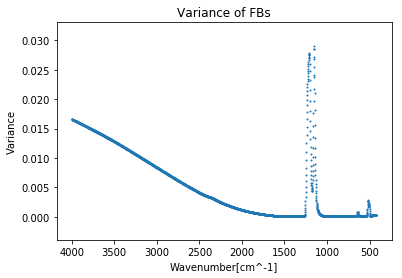

In [17]:
scaler = StandardScaler()
scaler.fit(FBs)
FBs_Std = scaler.transform(FBs)

plt.scatter(wave_no,scaler.var_, s=1)
ax = plt.gca()
ax.invert_xaxis()
ax.set_title('Variance of FBs')
ax.set_xlabel('Wavenumber[cm^-1]')
ax.set_ylabel('Variance')

We can remove all the features with variance larger than 0.01


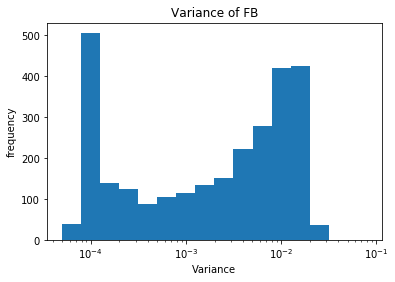

In [18]:
bins = np.power(10.0,(np.arange(-4.3,-1,0.2)))
plt.xscale('log')
plt.hist(scaler.var_,bins=bins)
plt.title('Variance of FB')
plt.xlabel('Variance')
plt.ylabel('frequency')
print('We can remove all the features with variance larger than 0.01')

In [19]:
idx_low_var_FB = np.argwhere(scaler.var_<0.01).flatten()
x_tr_filtered = x_tr.iloc[:,idx_low_var_FB]
x_te_filtered = x_te.iloc[:,idx_low_var_FB]

## Applying PCA to the low variance x_tr
Now that we removed the noise from the FB, we can apply PCA and check the minimum number of features without losing
too much information.

In [20]:
#Trick to gain memory storage and reduce computational time. 
#Converting float64 to float32 as we don't need more than 6 decimals
x_tr_filtered32 = x_tr_filtered.apply(pd.to_numeric, downcast="float")
x_te_filtered32 = x_te_filtered.apply(pd.to_numeric, downcast="float")
x_tr_filtered32.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13362 entries, CRLA1_04_21_2015_NM_0_csv to SAWE1_02_05_2015_NM_0_csv
Columns: 2085 entries, 637 to 2783
dtypes: float32(2085)
memory usage: 106.4+ MB


In [21]:
# Check performance of pca models with different number of components
max_pca_feat = 400

def compute_scores(X,y):
    """Compute cross-validation on pca model with different number of components"""
    pca = PCA()
    pca_scores = []
    
    for n_feat in range(1,max_pca_feat):
        pca.n_components = n_feat
        pca_scores.append(np.mean(cross_val_score(pca,X,y, cv=3)))
        print(n_feat)
    return pca_scores

In [22]:
# trick: Use pickle to avoid recalculating
import pickle

def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def save_pickle(result, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(result, file)

def features_computation(X,y):
    try:
        return load_pickle('./pca_cv_scores.pickle')
    except (FileNotFoundError, EOFError) as e:
        pca_scores = compute_scores(X,y)
        save_pickle(pca_scores, './pca_cv_scores.pickle')
        return pca_scores

In [472]:
# compute cv_score of pca models with different number of components
import time
t0 = time.time()
pca_scores = features_computation(x_tr_filtered32,y_tr_der)
t1 = time.time()
print("Computational Time = ", t1-t0)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [23]:
# Apply PCA and keep all components
pca = PCA()
pca_tr = pca.fit_transform(x_tr_filtered32)
pca_te = pca.transform(x_te_filtered32)

In [509]:
# Check the number of feature to get 99% of variance explained
ind = np.argwhere(np.around(np.cumsum(pca.explained_variance_ratio_),3) > 0.99)
ind99 =  ind[0]

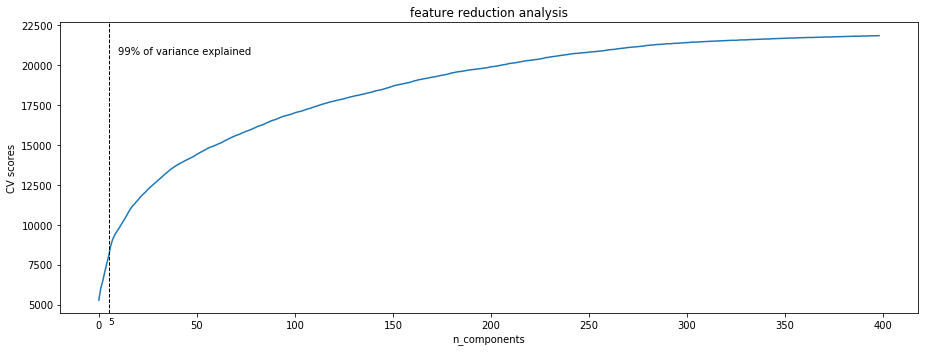

In [542]:
# Display plot to help determine how many features to keep without loosing too much information
fig = plt.figure(figsize=(13,5))
ax1 = sns.lineplot(x=np.arange(len(pca_scores)),y=pca_scores)
ax1.set_xlabel("n_components")
ax1.set_ylabel("CV scores")
ax1.set_title("feature reduction analysis")
plt.axvline(x=ind99, color="black", linewidth=1, linestyle="--")
plt.text(10,20700,"99% of variance explained",rotation=0)
plt.text(5,3750,"5",rotation=0, fontsize=9)

plt.tight_layout()
plt.show()

In [24]:
# From above plot we decided to keep 200 components (~10% of initial size) where it seems to reach a plateau
# We could keep less as 99% of variance is explained by only 5 components.
# But keeping ~10% of the data is already a huge reduction.
pca.n_components = 200
pca_tr = pca.fit_transform(x_tr_filtered32)
pca_te = pca.transform(x_te_filtered32)

In [25]:
np.shape(pca_tr)

(13362, 200)

# Model Comparison 
We will proceed to compare different regression models on the raw data, the filtered 2nd derivative data and the PC data.  We will compare them using 2 metrics: the bias metric (explained below) and the r2. The best model will minimize both of these quantities. 

##  Useful Functions

# Bias metric
This metric will allow us to compare the models based on their bias. It will compute the bias as y=(y_pred-y)/y_uc where y_uc is the signal uncertainty, y is the true y value and y_pred is the prediction from the model. It will also compute the signal to noise ratio (SNR) as y/y_uc. Then, it will smoothen the data by taking a moving average with 10% of the data. 

In [25]:
def compute_bias_metric_noplot(bias, SNR):
    
    # k = percent of data size for smoothing
    k = 0.1
    
    
    # take only samples with SNR > 2
    SNR_ind2 = np.argwhere(SNR > 2).flatten()
    # Bandwidth 
    bandwidth = round(k*len(SNR_ind2))
    # Normalize bias
    bias_n = np.array(bias[SNR_ind2]).flatten()
    # Stack to sort
    
    data = np.stack((np.array(SNR[SNR_ind2]).flatten(),bias_n),axis=0)
    data_sorted = data[:,data.argsort()[0]] #sort with respect to SNR
    y=[]
    for i in range(int(1/k)):
            y.append(np.mean(data_sorted[1,i*bandwidth:(i+1)*bandwidth]))
           
    # Smoother = Moving average, bandwidth of 10% of Data
    return np.max(np.abs(y))

## Cross Validation
This function will perform random cross validation. At each fold it will evaluate the bias metric, the MSE and the r2 with respect to the test sample, which is chosen randomly. The function build-k indices generates an array of k rows containing equal number of indices on each row. Each fold will take a row of this matrix as the test set. Additionally, the function plots the y_pred,y_true on the left, and will give the bias plot as well. 

In [26]:
def build_k_indices(y, k_fold, seed):
    """Permutates data randomly and organizes indices in k rows"""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]

    return np.array(k_indices)

In [27]:
def cross_validation_random(x_tr,y_tr,y_uc,regression_method,plot_title,k_fold=4,seed=1):
    """Splits training data into train and test. 
    cv_type = str representing how the test and train samples will be split
    Random Cross Validation split into k -folds. 
    Function outputs validation bias plot and regression plot
    Function outputs avg mse, r2, bias metric, and sample size
    """
    reg=eval(regression_method)
    indices=build_k_indices(y_tr,k_fold,seed)
        
    avg_mse = 0
    avg_r2 = 0
    avg_bias = 0
    
    y_pred_shuffled = []
    y_true_shuffled = []
    uc_shuffled = []
    
    for k in range(k_fold):
            #training sub data
            x_te_sub = x_tr.iloc[indices[k],:]
            y_te_sub = y_tr[indices[k]]
            y_te_sub_uc = y_uc[indices[k]]
            

            #drop training indices, select test subdata
            #indices_ = np.delete(indices, (k), axis=0).flatten() #Take the complement of the data as test
            indices_ = np.delete(indices, (k), axis=0).flatten()[:int(len(y_tr)/2)] #take half of the train data
            x_tr_sub = x_tr.iloc[indices_,:]
            y_tr_sub = y_tr[indices_]
            

            reg.fit(x_tr_sub,y_tr_sub)
            y_te_sub_pred = reg.predict(x_te_sub)
            
            
            #Bias Calculation
            SNR_sub = y_te_sub/y_te_sub_uc
            bias_te_sub = (y_te_sub_pred - y_te_sub) / y_te_sub_uc
            bias_metric = compute_bias_metric_noplot(bias_te_sub,SNR_sub)
            
            #Compute loss and r2
            avg_mse = avg_mse+mean_squared_error(y_te_sub,y_te_sub_pred)
            avg_r2 = avg_r2+ r2_score(y_te_sub, y_te_sub_pred)
            avg_bias = avg_bias + bias_metric
            
            #Plot 
            plt.scatter(y_te_sub,y_te_sub_pred, alpha=0.75)
            y_pred_shuffled.append(y_te_sub_pred)
            y_true_shuffled.append(y_te_sub)
            uc_shuffled.append(y_te_sub_uc)
            
            print('Fold # %i Test mean squared error: %.2f' % (k+1,mean_squared_error(y_te_sub, y_te_sub_pred)))
            print('Fold # %i Test R2: %.2f' % (k+1,r2_score(y_te_sub, y_te_sub_pred)))
            print('Fold # %i Test bias metric: %.2f' % (k+1,bias_metric))
    print('Training Sample Size: ',int(len(y_tr)*(k_fold-1)/k_fold))
    plt.suptitle(plot_title, fontsize=20)
    u = np.linspace(0,500)
    plt.plot(u,u, c='black')
    plt.xlabel('y_true', fontsize=18)
    plt.ylabel('y_pred_cv', fontsize=16)
    plt.show()
    
   
    bias_plot(pd.Series(np.array(y_true_shuffled).flatten()),np.array(y_pred_shuffled).flatten(),np.array(uc_shuffled).flatten())
    return  avg_mse/k_fold,avg_r2/k_fold,avg_bias/k_fold,int(len(y_tr)*(k_fold-1)/k_fold)

In [28]:
def bias_plot(y_right, y_pred, OCU, ax_=None):
    """Produces a nice visualization of the bias"""
    bias = (y_pred - y_right) / OCU
    SNR = y_right / OCU
    SNR.name = 'SNR'
    bias.name = 'bias'
    pd_plot = pd.concat([SNR, bias], axis=1)


    sns.jointplot("SNR", "bias", data=pd_plot, kind='reg', scatter_kws={"s": 2},
                  joint_kws={'line_kws':{'color':'black'}},ax=ax_)
    

## Linear Regression Raw Data
We will start with the simplest model on the raw data

Fold # 1 Test mean squared error: 6.79
Fold # 1 Test R2: 0.98
Fold # 1 Test bias metric: 0.42
Fold # 2 Test mean squared error: 6.63
Fold # 2 Test R2: 0.97
Fold # 2 Test bias metric: 0.23
Fold # 3 Test mean squared error: 6.62
Fold # 3 Test R2: 0.97
Fold # 3 Test bias metric: 0.32
Fold # 4 Test mean squared error: 9.75
Fold # 4 Test R2: 0.97
Fold # 4 Test bias metric: 0.32
Training Sample Size:  10021


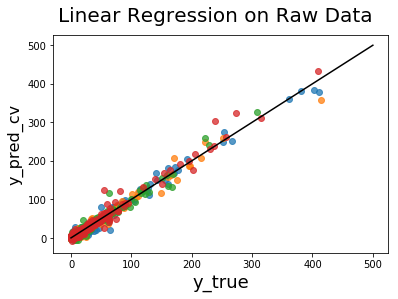

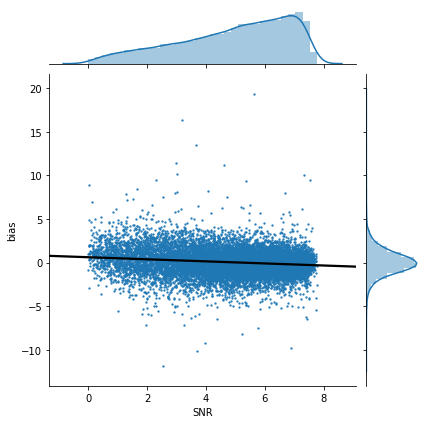

In [175]:
MSE_lin,R2_lin,Biasm_lin,train_size = cross_validation_random(x_tr,y_tr,df_OCU_tr,'LinearRegression()','Linear Regression on Raw Data',4) #Raw model

## Linear Regression on Derivative Data

Fold # 1 Test mean squared error: 5.71
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.63
Fold # 2 Test mean squared error: 7.26
Fold # 2 Test R2: 0.97
Fold # 2 Test bias metric: 0.59
Fold # 3 Test mean squared error: 4.72
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.70
Fold # 4 Test mean squared error: 6.59
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.65
Training Sample Size:  10021
Average MSE: 6.07
Average R2: 0.98
Average Bias Metric: 0.64


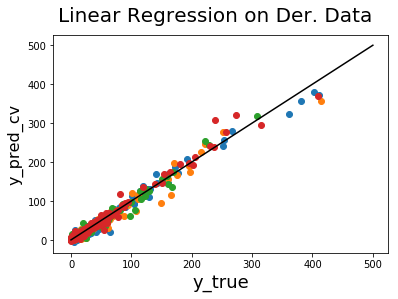

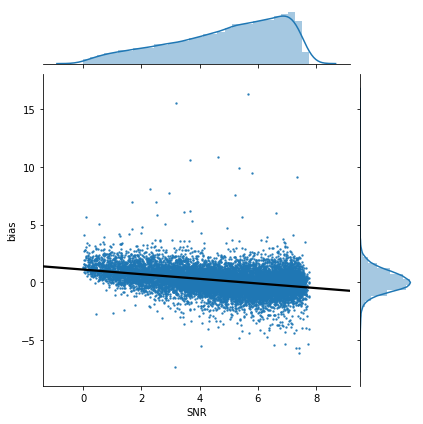

In [163]:
MSE_lin_der,R2_lin_der,Biasm_lin_der,train_size = cross_validation_random(x_tr_der,y_tr,df_OCU_tr,'LinearRegression()','Linear Regression on Der. Data',4) #Raw model

## Linear Regression Filtered Derivative Data

Fold # 1 Test mean squared error: 5.91
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.35
Fold # 2 Test mean squared error: 5.96
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.21
Fold # 3 Test mean squared error: 6.24
Fold # 3 Test R2: 0.97
Fold # 3 Test bias metric: 0.36
Fold # 4 Test mean squared error: 8.16
Fold # 4 Test R2: 0.97
Fold # 4 Test bias metric: 0.38
Training Sample Size:  10021


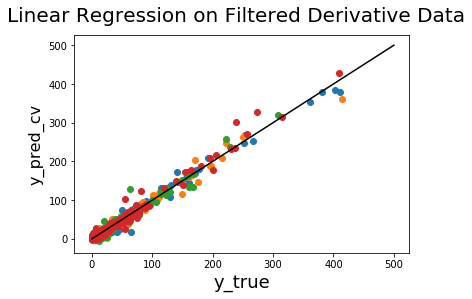

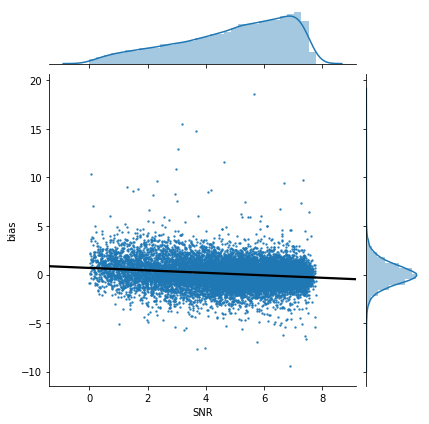

In [56]:
MSE_lin_der_filtered,R2_lin_der_filtered,Biasm_lin_der_filtered,train_size = cross_validation_random(x_tr_der_filtered,y_tr,df_OCU_tr,'LinearRegression()','Linear Regression on Filtered Derivative Data',4) #der data

## Linear Regression on PC Set

Fold # 1 Test mean squared error: 5.42
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.45
Fold # 2 Test mean squared error: 5.64
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.45
Fold # 3 Test mean squared error: 4.88
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.48
Fold # 4 Test mean squared error: 6.29
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.49
Training Sample Size:  10021


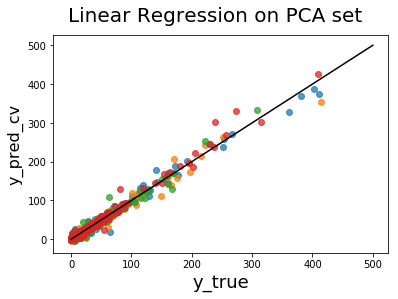

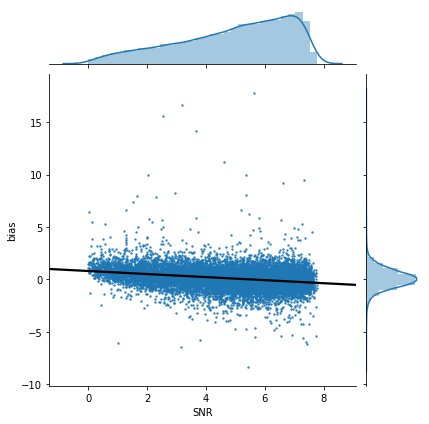

In [176]:
MSE_lin_PCA,R2_lin_PCA,Biasm_lin_PCA,train_size = cross_validation_random(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,'LinearRegression()','Linear Regression on PCA set',4) #der data

Comparing the three data sets, it seems that the PCA linear regression gives very good results

## Ridge Regression Raw Data
We will implement ridge regression. We will select the appropriate lambda from the training data

In [43]:
rdge = RidgeCV(alphas=(1e-4,1e-5,1e-6,1e-7))
rdge.fit(x_tr,y_tr)
alpha_raw = rdge.alpha_

In [44]:
print(alpha_raw)

0.0001


Fold # 1 Test mean squared error: 5.37
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.46
Fold # 2 Test mean squared error: 5.27
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.42
Fold # 3 Test mean squared error: 4.41
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.51
Fold # 4 Test mean squared error: 5.66
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.42
Training Sample Size:  10021


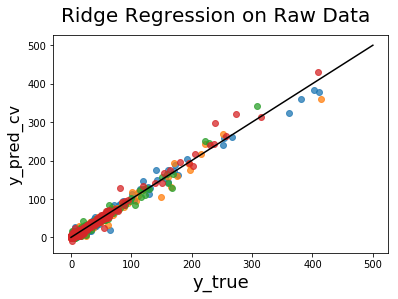

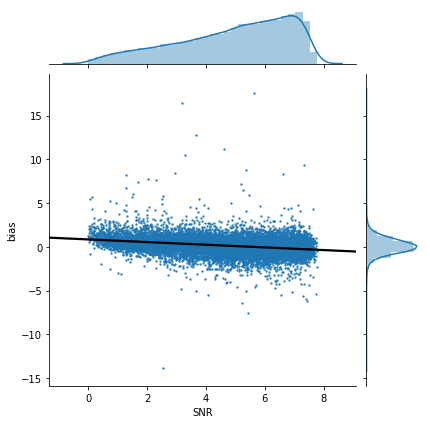

In [177]:
MSE_ridge,R2_ridge,Biasm_ridge,train_size = cross_validation_random(x_tr,y_tr,df_OCU_tr,'Ridge(alpha=1e-4)','Ridge Regression on Raw Data',4) #Raw model

## Ridge Regression 2nd Derivative

In [46]:
rdge.fit(x_tr_der,y_tr)
print(rdge.alpha_)

1e-07


Fold # 1 Test mean squared error: 5.40
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.49
Fold # 2 Test mean squared error: 5.63
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.45
Fold # 3 Test mean squared error: 4.29
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.57
Fold # 4 Test mean squared error: 5.92
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.54
Training Sample Size:  10021


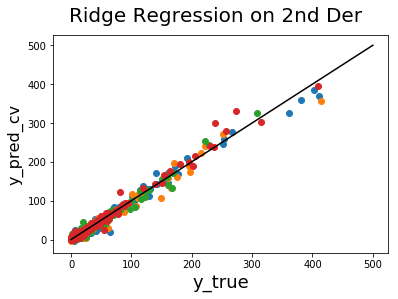

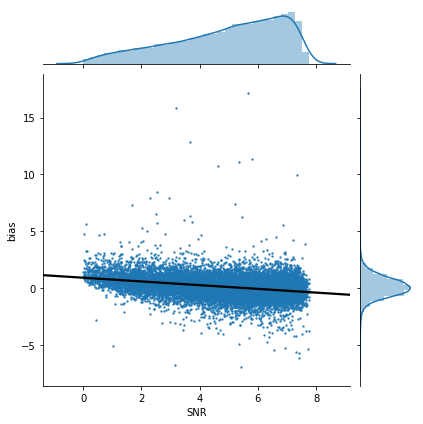

In [47]:
MSE_ridge_der,R2_ridge_der,Biasm_ridge_der,train_size = cross_validation_random(x_tr_der,y_tr,df_OCU_tr,'Ridge(alpha=1e-7)','Ridge Regression on 2nd Der',4) #Raw model

## Ridge Regression Filtered 2nd Derivative

In [48]:
rdge.fit(x_tr_der_filtered,y_tr)
print(rdge.alpha_)

1e-07


Fold # 1 Test mean squared error: 5.39
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.49
Fold # 2 Test mean squared error: 5.64
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.45
Fold # 3 Test mean squared error: 4.29
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.58
Fold # 4 Test mean squared error: 5.94
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.54
Training Sample Size:  10021


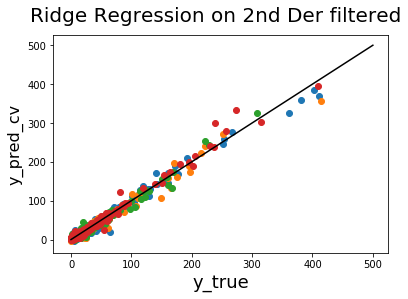

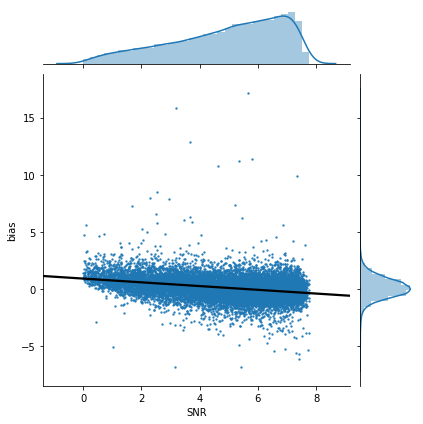

In [49]:
MSE_ridge_der_filtered,R2_ridge_der_filtered,Biasm_ridge_der_filtered,train_size = cross_validation_random(x_tr_der_filtered,y_tr,df_OCU_tr,'Ridge(alpha=1e-7)','Ridge Regression on 2nd Der filtered',4) #Raw model

## Ridge Regression PC Set

In [50]:
rdge.fit(pca_tr,y_tr)
print(rdge.alpha_)

0.0001


Fold # 1 Test mean squared error: 5.42
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.48
Fold # 2 Test mean squared error: 5.72
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.47
Fold # 3 Test mean squared error: 4.21
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.52
Fold # 4 Test mean squared error: 5.89
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.54
Training Sample Size:  10021


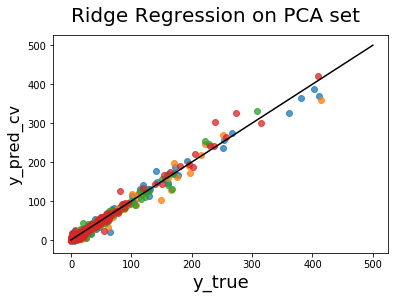

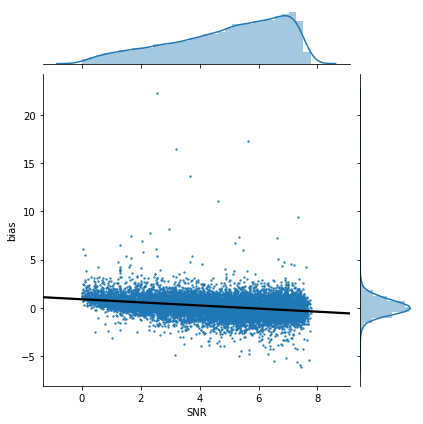

In [178]:
MSE_ridge_pca,R2_ridge_pca,Biasm_ridge_pca,train_size = cross_validation_random(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,'Ridge(alpha=1e-4)','Ridge Regression on PCA set',4) #Raw model

# Elastic Net CV on Filtered Data
Since this model is computationally intensive, we decided to compare only the filtered raw data and derivative

## Filtered Derivative

In [179]:
EN = ElasticNetCV(alphas=[1e-3,1e-4,1e-5,1e-6],l1_ratio=([.3,.9, .95,.98,.985,0.99,1]),cv=3,max_iter=3000)
EN.fit(x_tr_der_filtered,y_tr)

ElasticNetCV(alphas=[0.001, 0.0001, 1e-05, 1e-06], copy_X=True, cv=3,
       eps=0.001, fit_intercept=True,
       l1_ratio=[0.3, 0.9, 0.95, 0.98, 0.985, 0.99, 1], max_iter=3000,
       n_alphas=100, n_jobs=None, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [180]:
print('optimal alpha: ',EN.alpha_)
print('optimal l1_ratio:',EN.l1_ratio_)

optimal alpha:  1e-06
optimal l1_ratio: 1.0


In [ ]:
MSE_EN_der_filtered,R2_EN_der_filtered,Biasm_EN_der_filtered,train_size = cross_validation_random(x_tr_der_filtered,y_tr,df_OCU_tr,'ElasticNet(alpha=1e-6,l1_ratio=1,max_iter=3000)','Elastic Net l1_ratio=1,alpha=1e-6',4) #Raw model

Fold # 1 Test mean squared error: 5.70
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.68


##  ELastic Net on PC Set

In [97]:
EN = ElasticNetCV(alphas=[1e-3,1e-4,1e-5,1e-6],l1_ratio=([.3,.9, .95,.98,.985,0.99,1]),cv=4,max_iter=2000)
EN.fit(pd.DataFrame(pca_tr),y_tr)

ElasticNetCV(alphas=[0.001, 0.0001, 1e-05, 1e-06], copy_X=True, cv=4,
       eps=0.001, fit_intercept=True,
       l1_ratio=[0.3, 0.9, 0.95, 0.98, 0.985, 0.99, 1], max_iter=2000,
       n_alphas=100, n_jobs=None, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [98]:
print('optimal alpha: ',EN.alpha_)
print('optimal l1_ratio:',EN.l1_ratio_)

optimal alpha:  1e-06
optimal l1_ratio: 0.985


Fold # 1 Test mean squared error: 5.46
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.48
Fold # 2 Test mean squared error: 5.77
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.47
Fold # 3 Test mean squared error: 4.22
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.52
Fold # 4 Test mean squared error: 5.87
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.54
Training Sample Size:  10021


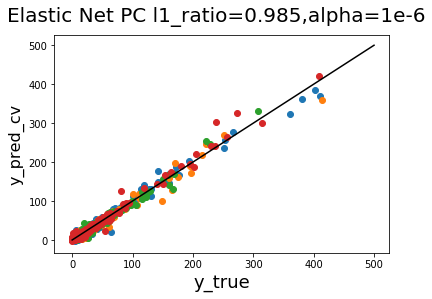

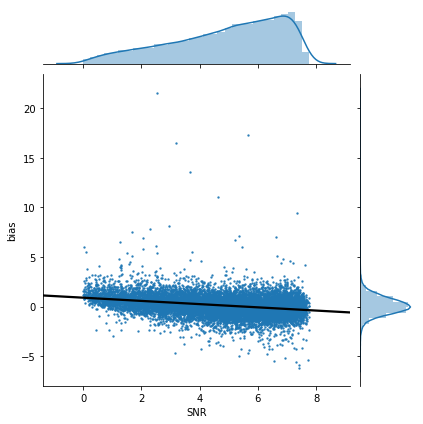

In [99]:
MSE_EN_pca,R2_EN_pca,Biasm_EN_pca,train_size = cross_validation_random(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,'ElasticNet(alpha=1e-6,l1_ratio=0.985,max_iter=3000)','Elastic Net PC l1_ratio=0.985,alpha=1e-6',4) #Raw model

# Neural Net on PC Data
Even though it was desired to do a nn on the other sets, their large size made it too computationally intensive, so only the pc set will be considered. We will first try to find the best combination of parameters to optimize the nn, and then we will compare it with the other models. We will use only one hidden layer because we don't want to overfit the system. Therefore, we will vary the regularizer and the size of the hidden layer.  

## PC Set

Fold # 1 Test mean squared error: 5.60
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.20
Fold # 2 Test mean squared error: 5.41
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.35
Fold # 3 Test mean squared error: 4.39
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.27
Fold # 4 Test mean squared error: 5.31
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.21
Training Sample Size:  10021


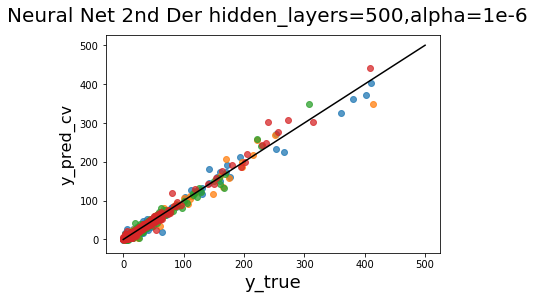

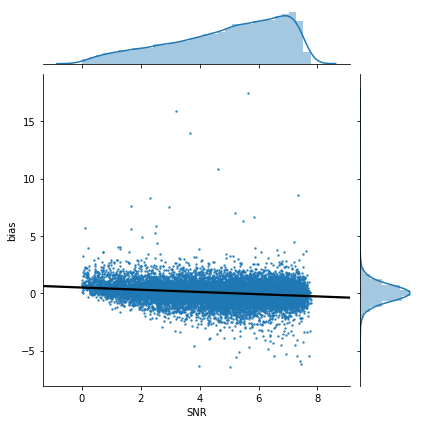

In [29]:
MSE_NN_pca,R2_NN_pca,Biasm_NN_pca,train_size = cross_validation_random(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,'MLPRegressor(hidden_layer_sizes=(500,),alpha=1e-6,batch_size=200,max_iter=400)','Neural Net 2nd Der hidden_layers=500,alpha=1e-6',4) #Raw model

# NN Finding the optimal number of hidden layers and alpha for PC Set
We are intersted in finding the best size of the hidden layer and the best alpha.

In [30]:
def cross_validation_no_plot(x_tr,y_tr,y_uc,regression_method,k_fold=4,seed=1):
    """Splits training data into train and test. 
    cv_type = str representing how the test and train samples will be split
    Random Cross Validation split into k -folds. 
    Function outputs avg mse, r2, bias metric
    """
    reg=eval(regression_method)
    indices=build_k_indices(y_tr,k_fold,seed)
        
    avg_mse = 0
    avg_r2 = 0
    avg_bias = 0
    
    y_pred_shuffled = []
    y_true_shuffled = []
    uc_shuffled = []
    
    for k in range(k_fold):
            #training sub data
            x_te_sub = x_tr.iloc[indices[k],:]
            y_te_sub = y_tr[indices[k]]
            y_te_sub_uc = y_uc[indices[k]]
            

            #drop training indices, select test subdata
            #indices_ = np.delete(indices, (k), axis=0).flatten() #Take the complement of the data as test
            indices_ = np.delete(indices, (k), axis=0).flatten()[:int(len(y_tr)/2)] #take half of the train data
            x_tr_sub = x_tr.iloc[indices_,:]
            y_tr_sub = y_tr[indices_]
            

            reg.fit(x_tr_sub,y_tr_sub)
            y_te_sub_pred = reg.predict(x_te_sub)
            
            
            #Bias Calculation
            SNR_sub = y_te_sub/y_te_sub_uc
            bias_te_sub = (y_te_sub_pred - y_te_sub) / y_te_sub_uc
            bias_metric = compute_bias_metric_noplot(bias_te_sub,SNR_sub)
            
            #Compute loss and r2
            avg_mse = avg_mse+mean_squared_error(y_te_sub,y_te_sub_pred)
            avg_r2 = avg_r2+ r2_score(y_te_sub, y_te_sub_pred)
            avg_bias = avg_bias + bias_metric
            
            #Plot 
            #plt.scatter(y_te_sub,y_te_sub_pred)
            #y_pred_shuffled.append(y_te_sub_pred)
            #y_true_shuffled.append(y_te_sub)
            #uc_shuffled.append(y_te_sub_uc)
            
            print('Fold # %i Test mean squared error: %.2f' % (k+1,mean_squared_error(y_te_sub, y_te_sub_pred)))
            print('Fold # %i Test R2: %.2f' % (k+1,r2_score(y_te_sub, y_te_sub_pred)))
            print('Fold # %i Test bias metric: %.2f' % (k+1,bias_metric))
    print(regression_method)
    print('Training Sample Size: ',int(len(y_tr)*(k_fold-1)/k_fold)) 
    print('average mse: ', avg_mse/k_fold)
    print('average r2: ',avg_r2/k_fold)
    print('average bias: ',avg_bias/k_fold)
   
    #bias_plot(pd.Series(np.array(y_true_shuffled).flatten()),np.array(y_pred_shuffled).flatten(),np.array(uc_shuffled).flatten())
    return  avg_mse/k_fold, avg_r2/k_fold , avg_bias/k_fold , int(len(y_tr)*(k_fold-1)/k_fold)

In [57]:
"""Variable Initialization"""
alphas = np.logspace(-7,-3,5)

hidden_layers = np.arange(100,700,100)

mse_nn_pca_merged=pd.DataFrame(data=None, index=alphas, columns=hidden_layers)
r2_nn_pca_merged=pd.DataFrame(data=None, index=alphas, columns=hidden_layers)
biasm_nn_pca_merged=pd.DataFrame(data=None, index=alphas, columns=hidden_layers)

In [59]:
"""Grid search for size of layer and alpha"""
try:
    mse_nn_pca_merged, r2_nn_pca_merged,  biasm_nn_pca_merged, train_size = load_pickle('./heatmap_OC.pickle')
except (FileNotFoundError, EOFError) as e:
    for alpha_ in alphas:
    
        for hidden_layer in hidden_layers:
            reg_method = 'MLPRegressor(hidden_layer_sizes=(%d,),alpha=%.7f,batch_size=200,max_iter=400)'%(hidden_layer,alpha_)
            print(reg_method)
       
            mse_nn_pca_merged.loc[alpha_,hidden_layer], r2_nn_pca_merged.loc[alpha_,hidden_layer],  biasm_nn_pca_merged.loc[alpha_,hidden_layer], train_size =  cross_validation_no_plot(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,reg_method)
    
    save_pickle((mse_nn_pca_merged, r2_nn_pca_merged,  biasm_nn_pca_merged, train_size),'./heatmap_OC.pickle')


MLPRegressor(hidden_layer_sizes=(600,),alpha=0.0000001,batch_size=200,max_iter=400)
Fold # 1 Test mean squared error: 6.33
Fold # 1 Test R2: 0.98
Fold # 1 Test bias metric: 0.14
Fold # 2 Test mean squared error: 5.42
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.26
Fold # 3 Test mean squared error: 4.35
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.26
Fold # 4 Test mean squared error: 5.53
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.22
MLPRegressor(hidden_layer_sizes=(600,),alpha=0.0000001,batch_size=200,max_iter=400)
Training Sample Size:  10021
average mse:  5.405651369562078
average r2:  0.9812376004062839
average bias:  0.2211050526381269
MLPRegressor(hidden_layer_sizes=(600,),alpha=0.0000010,batch_size=200,max_iter=400)
Fold # 1 Test mean squared error: 6.34
Fold # 1 Test R2: 0.98
Fold # 1 Test bias metric: 0.14
Fold # 2 Test mean squared error: 5.42
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.26
Fold # 3 Test mean squared error: 4.42
Fold # 3 Test R2: 

We can portray the data using a heat map. We will select the combination with the highest r2 and the smallest bias. We will try to find the minimum bias,(1-r2). However, we need to ensure that both parameters are equally weighted if we compute the norm. Hence we want to minimize bias,k(1-r2), where k is the weighting factor such that bias and (1-r2) have similar magnitudes. 

In [148]:
print('k(1-r2)^2\n',(10*(1-r2_nn_pca_merged.astype('float')))**2,'\n')
print('bias metric^2\n',biasm_nn_pca_merged.astype('float')**2,'\n')
print('We see that k = 10 ensures that both quantities are approximately equally weighted')

k(1-r2)^2
                    100       200       300       400       500       600
1.000000e-07  0.031542  0.031141  0.034040  0.031996  0.032775  0.035203
1.000000e-06  0.031850  0.031098  0.034231  0.032194  0.033111  0.035568
1.000000e-05  0.031910  0.031341  0.033132  0.032396  0.033182  0.035534
1.000000e-04  0.031633  0.031260  0.033059  0.032063  0.032951  0.036628
1.000000e-03  0.032515  0.033123  0.035641  0.035474  0.034483  0.035634 

bias metric^2
                    100       200       300       400       500       600
1.000000e-07  0.094761  0.101933  0.069923  0.101611  0.081582  0.048887
1.000000e-06  0.095361  0.098535  0.084356  0.105428  0.066613  0.050461
1.000000e-05  0.094403  0.101567  0.075020  0.093951  0.058304  0.046932
1.000000e-04  0.092622  0.103497  0.116258  0.108494  0.080941  0.088175
1.000000e-03  0.098731  0.072308  0.141376  0.080393  0.092433  0.099823 

We see that k = 10 ensures that both quantities are approximately equally weighted


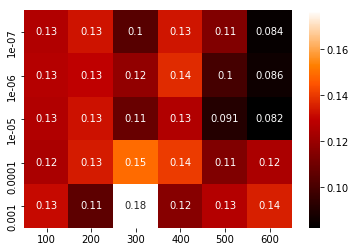

In [149]:
sns.heatmap(biasm_nn_pca_merged.astype('float')**2+(10*(1-r2_nn_pca_merged.astype('float')))**2,annot=True,cmap='gist_heat')

We see that 600 layers and alpha=1e-5 seems to be the best choice.

Fold # 1 Test mean squared error: 5.89
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.15
Fold # 2 Test mean squared error: 5.49
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.24
Fold # 3 Test mean squared error: 4.32
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.28
Fold # 4 Test mean squared error: 5.14
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.30
Training Sample Size:  10021


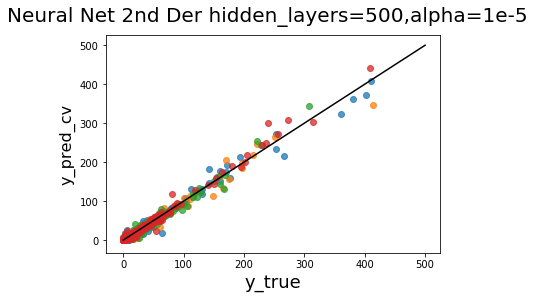

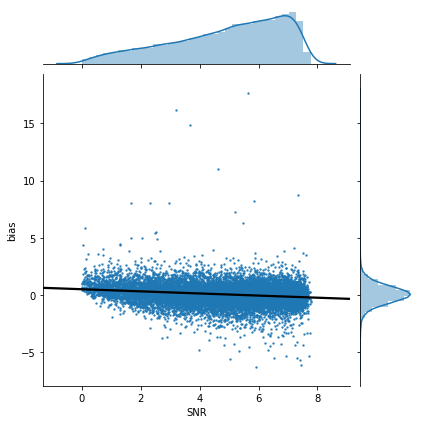

In [53]:
MSE_NN_pca,R2_NN_pca,Biasm_NN_pca,train_size = cross_validation_random(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,'MLPRegressor(hidden_layer_sizes=(500,),alpha=1e-5,batch_size=200,max_iter=400)','Neural Net 2nd Der hidden_layers=500,alpha=1e-5',4) #Raw model

# Comparison Summary

In [186]:
 model_info = {'Dataset/Model': ['linear','der_linear','der_linear_filtered','linear_pca(200 comps)','Ridge','Ridge_der',\
          'Ridge_der_filtered','Ridge_pca','EN_der_filtered','EN_pca','NN_pca']\
         , 'MSE': [MSE_lin,MSE_lin_der,MSE_lin_der_filtered,MSE_lin_PCA,MSE_ridge,MSE_ridge_der,\
                  MSE_ridge_der_filtered,MSE_ridge_pca,MSE_EN_der_filtered,MSE_EN_pca,MSE_NN_pca]\
        ,'R2': [R2_lin,R2_lin_der,R2_lin_der_filtered,R2_lin_PCA,R2_ridge,R2_ridge_der,R2_ridge_der_filtered,\
                R2_ridge_pca,R2_EN_der_filtered,R2_EN_pca,R2_NN_pca]\
            ,'Bias Metric': [Biasm_lin,Biasm_lin_der,Biasm_lin_der_filtered,Biasm_lin_PCA,Biasm_ridge,Biasm_ridge_der,Biasm_ridge_der_filtered,\
                             Biasm_ridge_pca,Biasm_EN_der_filtered,Biasm_EN_pca,Biasm_NN_pca]}
pd_model_info = pd.DataFrame(model_info).set_index('Dataset/Model')

In [187]:
pd_model_info

,Bias Metric,MSE,R2
Dataset/Model,,,
linear,0.321824,7.447211,0.973716
der_linear,0.642369,6.073772,0.978515
der_linear_filtered,0.323040,6.566569,0.976608
linear_pca(200 comps),0.465625,5.552583,0.980347
Ridge,0.454819,5.177631,0.981787
Ridge_der,0.513906,5.310279,0.981359
Ridge_der_filtered,0.516304,5.315318,0.981342
Ridge_pca,0.501774,5.309197,0.981384
EN_der_filtered,0.704342,6.310196,0.977430


In [189]:
pd_model_info.to_csv('Comparison_models_OC')

In [150]:
# Function to plot and choose best model
# to avoid overlapping text
def annote(i,txt,ax, r2_new, df):
    if i == 4:
        ax.annotate(txt,(r2_new[i]-.0003, df["Bias Metric"][i]+.03))
    if i == 5:
        ax.annotate(txt,(r2_new[i], df["Bias Metric"][i]+.06))
    if i == 6:
        ax.annotate(txt,(r2_new[i], df["Bias Metric"][i]+.09))
    if i == 7:
        ax.annotate(txt,(r2_new[i], df["Bias Metric"][i]+.14))
    if i == 9:
        ax.annotate(txt,(r2_new[i], df["Bias Metric"][i]+.04))
        
def choose_best(df):
    n = df["Dataset/Model"]
    r2_new = 1-np.array(df["R2"])
    fig, ax = plt.subplots()
    
    ax.scatter(r2_new,df["Bias Metric"], marker="o", s=100, alpha=0.255)
    ax.set_ylabel('Bias_metric')
    ax.set_xlabel('1 - R2')
    plt.subplots_adjust(left=0, bottom=0, right=2, top=1, wspace=None, hspace=None)
    ax.set_xlim([0.016, 0.028])
    
    for i, txt in enumerate(n):
        
        if (i == 4 or i == 5 or i == 6 or i == 7 or i==9) :
            annote(i,txt,ax, r2_new, df)
        else:
            ax.annotate(txt, (r2_new[i], df["Bias Metric"][i]+.03))
            
    distance = []
    for elem1, elem2 in zip(r2_new,df["Bias Metric"]):
           distance.append(np.linalg.norm([elem1*10,elem2])) #multiply (1-r2) by k=10
            
    plt.title("Comparison of performance")
    plt.show()
    min_dist = np.argsort(distance)
    print("Best model: ", n[min_dist[0]], ", Second: ", n[min_dist[1]], ", Third: ", n[min_dist[2]])

To compare the data, we will plot (1-r2) vs. the bias metric and we will select closest to the origin. In order for the r2 to be equally weighted to the bias we multiply (1-r2) by k=10 (see heat map for nn)

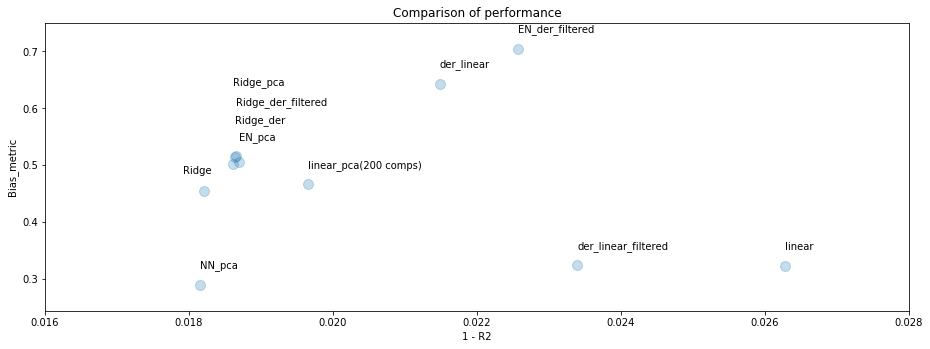

Best model:  NN_pca , Second:  der_linear_filtered , Third:  linear


In [151]:
cf_comp = pd.read_csv("Comparison_models_OC")
choose_best(cf_comp)

Based on this comparison, we conclude that the neural nets give the best overall performance. Since all the r2 seem to be close to each other, the second best model was the linear regression with the filtered 2nd derivative set. 

# Finding Min Sample Size

Now that we chose nn as our best model, we now want to see what is the smallest training size needed to achieve good predictions on any sample. Moreover, since all sites have on average an equal amount of samples, we can find the smallest number of sites required to achieve good prediction. Based on the previous comparison, we will set a threshold in the MSE of 10.

## Reverse Random Cross Validation
In order to find the min number of sites, we decided to switch the training and the test set in the random cross validation. This way, if the fold is increased, the train set will be decreased in size and still be compared with the rest of the data. In order to have a fair comparison, the test set will be taken to be half of the data. 

In [113]:
def cross_validation_sample_size(x_tr,y_tr,y_uc,regression_method,k_fold,seed):
    """Splits training data into train and test. 
    Train size is given by sample size.
    Does inverted k-fold because train sample is smallest:
    For example if the k_fold is 4, 1/4th of the data will be train, and 3/4th will be test. 
    """
    reg=eval(regression_method)
    indices=build_k_indices(y_tr,k_fold,seed)
    avg_mse = 0
    avg_r2 = 0
    avg_bias = 0
    train_size = int(len(y_tr)/k_fold)
    k_fold = min(30,k_fold) #limit number of iterations of for loop 
    for k in range(k_fold):
            #training sub data
            x_tr_sub = x_tr.iloc[indices[k],:]
            y_tr_sub = y_tr[indices[k]]
            

            #drop training indices, select test subdata
            #indices_ = np.delete(indices, (k), axis=0).flatten() #Take the complement of the data as test
            indices_ = np.delete(indices, (k), axis=0).flatten()[:int(len(y_tr)/2)] #take half of the train data
            x_te_sub = x_tr.iloc[indices_,:]
            y_te_sub = y_tr[indices_]
            y_te_sub_uc = y_uc[indices_] 

            reg.fit(x_tr_sub,y_tr_sub)
            y_te_sub_pred = reg.predict(x_te_sub)
            
            
            #Bias Calculation
            SNR_sub = y_te_sub/y_te_sub_uc
            bias_te_sub = (y_te_sub_pred - y_te_sub) / y_te_sub_uc
            bias_metric = compute_bias_metric_noplot(bias_te_sub,SNR_sub)
            
            #Compute loss and r2
            avg_mse = avg_mse+mean_squared_error(y_te_sub,y_te_sub_pred)
            avg_r2 = avg_r2+ r2_score(y_te_sub, y_te_sub_pred)
            avg_bias = avg_bias + bias_metric
            
            print('Fold # %i Test mean squared error: %.2f' % (k+1,mean_squared_error(y_te_sub, y_te_sub_pred)))
            print('Fold # %i Test R2: %.2f' % (k+1,r2_score(y_te_sub, y_te_sub_pred)))
            print('Fold # %i Test bias metric: %.2f' % (k+1,bias_metric))
    print('Training Sample Size: ',train_size)
    print('Average MSE: ',avg_mse/k_fold)
    print('Average R2: ', avg_r2/k_fold)
    print('Average bias metric',avg_bias/k_fold)
    return  avg_mse/k_fold,avg_r2/k_fold,avg_bias/k_fold,train_size

In [114]:
def Reg_model_performance_sample_size(x_tr,y_tr,y_uc,reg_method,ks):

## With this approach we will decrease the training size exponentially and hopefully find the point at which the model 
#is not giving correct results. 
    
    
    mse_vec = []
    r2_vec = []
    bias_vec =[]
    sample_size_vec = []
    for k in range(2,ks):
        k = int(2**k)
        mse,r2,bias,ss=cross_validation_sample_size(x_tr,y_tr,y_uc,reg_method,k,35) #increase k_fold
    
        mse_vec.append(mse)
        r2_vec.append(r2)
        bias_vec.append(bias)
        sample_size_vec.append(ss)
    return mse_vec,r2_vec,bias_vec,sample_size_vec
    

## Min Sample Size with Neural Net

Small demonstration using k=10, hl=600,alpha=1e-5

In [115]:
#Small demonstration using k=10 
cross_validation_sample_size(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,'MLPRegressor(hidden_layer_sizes=(600,),alpha=1e-5,batch_size=200,max_iter=400)',10,10)

Fold # 1 Test mean squared error: 7.65
Fold # 1 Test R2: 0.98
Fold # 1 Test bias metric: 0.43
Fold # 2 Test mean squared error: 15.96
Fold # 2 Test R2: 0.95
Fold # 2 Test bias metric: 0.21
Fold # 3 Test mean squared error: 11.46
Fold # 3 Test R2: 0.96
Fold # 3 Test bias metric: 0.38
Fold # 4 Test mean squared error: 11.30
Fold # 4 Test R2: 0.96
Fold # 4 Test bias metric: 0.30
Fold # 5 Test mean squared error: 9.35
Fold # 5 Test R2: 0.97
Fold # 5 Test bias metric: 0.40
Fold # 6 Test mean squared error: 10.88
Fold # 6 Test R2: 0.96
Fold # 6 Test bias metric: 0.40
Fold # 7 Test mean squared error: 8.90
Fold # 7 Test R2: 0.97
Fold # 7 Test bias metric: 0.31
Fold # 8 Test mean squared error: 7.43
Fold # 8 Test R2: 0.97
Fold # 8 Test bias metric: 0.43
Fold # 9 Test mean squared error: 6.62
Fold # 9 Test R2: 0.98
Fold # 9 Test bias metric: 0.40
Fold # 10 Test mean squared error: 10.81
Fold # 10 Test R2: 0.96
Fold # 10 Test bias metric: 0.25
Training Sample Size:  1336
Average MSE:  10.0355398

(10.035539894448743, 0.965382443200032, 0.3501286317755484, 1336)

Now we will use the function Reg_model_performance_sample_size to plot the performance as a function of sample size

In [153]:
try:
    mse_nn_vec_ss,r2_nn_vec_ss,sample_size_vec,biasm_nn_vec_ss = load_pickle('./samplesize_performance_oc.pickle')
except (FileNotFoundError, EOFError) as e:
    mse_nn_vec_ss,r2_nn_vec_ss,biasm_nn_vec_ss,sample_size_vec = Reg_model_performance_sample_size(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,'MLPRegressor(hidden_layer_sizes=(600,),alpha=1e-5,batch_size=200,max_iter=500)',8)

Fold # 1 Test mean squared error: 5.18
Fold # 1 Test R2: 0.98
Fold # 1 Test bias metric: 0.41
Fold # 2 Test mean squared error: 7.90
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.27
Fold # 3 Test mean squared error: 5.71
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.29
Fold # 4 Test mean squared error: 8.91
Fold # 4 Test R2: 0.97
Fold # 4 Test bias metric: 0.51
Training Sample Size:  3340
Average MSE:  6.926822630231908
Average R2:  0.9781138676810697
Average bias metric 0.3692281068900591
Fold # 1 Test mean squared error: 5.94
Fold # 1 Test R2: 0.98
Fold # 1 Test bias metric: 0.25
Fold # 2 Test mean squared error: 15.11
Fold # 2 Test R2: 0.96
Fold # 2 Test bias metric: 0.24
Fold # 3 Test mean squared error: 8.46
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.31
Fold # 4 Test mean squared error: 10.32
Fold # 4 Test R2: 0.97
Fold # 4 Test bias metric: 0.33
Fold # 5 Test mean squared error: 6.42
Fold # 5 Test R2: 0.98
Fold # 5 Test bias metric: 0.36
Fold # 6 Test mean sq

Fold # 23 Test mean squared error: 29.66
Fold # 23 Test R2: 0.91
Fold # 23 Test bias metric: 0.97
Fold # 24 Test mean squared error: 24.70
Fold # 24 Test R2: 0.92
Fold # 24 Test bias metric: 0.66
Fold # 25 Test mean squared error: 22.73
Fold # 25 Test R2: 0.92
Fold # 25 Test bias metric: 1.11
Fold # 26 Test mean squared error: 51.12
Fold # 26 Test R2: 0.84
Fold # 26 Test bias metric: 0.69
Fold # 27 Test mean squared error: 42.45
Fold # 27 Test R2: 0.87
Fold # 27 Test bias metric: 0.72
Fold # 28 Test mean squared error: 29.25
Fold # 28 Test R2: 0.91
Fold # 28 Test bias metric: 0.99
Fold # 29 Test mean squared error: 48.79
Fold # 29 Test R2: 0.85
Fold # 29 Test bias metric: 1.23
Fold # 30 Test mean squared error: 29.96
Fold # 30 Test R2: 0.90
Fold # 30 Test bias metric: 0.87
Training Sample Size:  208
Average MSE:  43.01439150044794
Average R2:  0.8630799493172482
Average bias metric 0.9068022301228631
Fold # 1 Test mean squared error: 49.66
Fold # 1 Test R2: 0.84
Fold # 1 Test bias metr

In [95]:
#save_pickle((mse_nn_vec_ss,r2_nn_vec_ss,sample_size_vec,biasm_nn_vec_ss), './samplesize_performance.pickle')

## Linear Regression on Filtered Second Derivative min Sample Size
We can also do the same analysis with our second best performing model

In [156]:
mse_lin_der_filtered_vec_ss,r2_lin_der_filtered_vec_ss,biasm_lin_der_filtered_vec_ss,sample_size_vec= Reg_model_performance_sample_size(x_tr_der_filtered,y_tr,df_OCU_tr,'LinearRegression()',8)

Fold # 1 Test mean squared error: 10.09
Fold # 1 Test R2: 0.96
Fold # 1 Test bias metric: 0.40
Fold # 2 Test mean squared error: 13.65
Fold # 2 Test R2: 0.96
Fold # 2 Test bias metric: 0.53
Fold # 3 Test mean squared error: 10.98
Fold # 3 Test R2: 0.97
Fold # 3 Test bias metric: 0.70
Fold # 4 Test mean squared error: 11.54
Fold # 4 Test R2: 0.96
Fold # 4 Test bias metric: 0.32
Training Sample Size:  3340
Average MSE:  11.567259788297248
Average R2:  0.9633584986518653
Average bias metric 0.4881208440696624
Fold # 1 Test mean squared error: 57.06
Fold # 1 Test R2: 0.80
Fold # 1 Test bias metric: 0.89
Fold # 2 Test mean squared error: 45.57
Fold # 2 Test R2: 0.88
Fold # 2 Test bias metric: 0.54
Fold # 3 Test mean squared error: 48.13
Fold # 3 Test R2: 0.86
Fold # 3 Test bias metric: 0.36
Fold # 4 Test mean squared error: 71.85
Fold # 4 Test R2: 0.81
Fold # 4 Test bias metric: 0.66
Fold # 5 Test mean squared error: 48.67
Fold # 5 Test R2: 0.84
Fold # 5 Test bias metric: 0.27
Fold # 6 Test

Fold # 23 Test mean squared error: 38.21
Fold # 23 Test R2: 0.88
Fold # 23 Test bias metric: 0.63
Fold # 24 Test mean squared error: 70.61
Fold # 24 Test R2: 0.76
Fold # 24 Test bias metric: 0.86
Fold # 25 Test mean squared error: 54.46
Fold # 25 Test R2: 0.82
Fold # 25 Test bias metric: 0.20
Fold # 26 Test mean squared error: 76.02
Fold # 26 Test R2: 0.76
Fold # 26 Test bias metric: 0.61
Fold # 27 Test mean squared error: 74.24
Fold # 27 Test R2: 0.77
Fold # 27 Test bias metric: 1.01
Fold # 28 Test mean squared error: 62.77
Fold # 28 Test R2: 0.80
Fold # 28 Test bias metric: 1.07
Fold # 29 Test mean squared error: 194.09
Fold # 29 Test R2: 0.39
Fold # 29 Test bias metric: 2.28
Fold # 30 Test mean squared error: 172.19
Fold # 30 Test R2: 0.45
Fold # 30 Test bias metric: 0.59
Training Sample Size:  208
Average MSE:  90.93056929942817
Average R2:  0.7088199296041473
Average bias metric 0.7246540243144733
Fold # 1 Test mean squared error: 132.20
Fold # 1 Test R2: 0.57
Fold # 1 Test bias m

## Comparison Plot

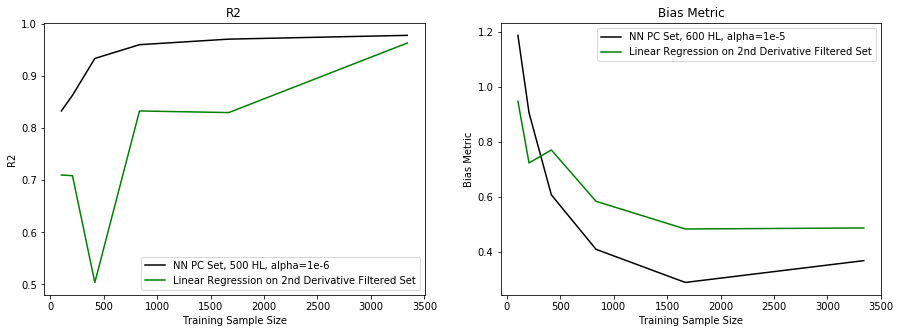

In [158]:
fig4 = plt.figure(figsize=(15,5))
"""ax1 = fig4.add_subplot(1,2,1)
ax1.plot(sample_size_vec_ridge,mse_nn_vec_ss,color='k',label='NN PC Set, 500 HL, alpha=1e-6')
ax1.plot(sample_size_vec_ridge,mse_ridge_vec_ss,color='g',label='Ridge raw data, alpha=1e-4')
ax1.set_xlabel('Training Sample Size')
ax1.set_ylabel('MSE')
ax1.set_title('MSE')
ax1.legend(('NN PC Set, 600 HL, alpha=1e-5','Linear Regression on 2nd Derivative Filtered Set'))"""
ax2 = fig4.add_subplot(1,2,1)
ax2.plot(sample_size_vec,r2_nn_vec_ss,color='k')
ax2.plot(sample_size_vec,r2_lin_der_filtered_vec_ss,color='g')
ax2.set_xlabel('Training Sample Size')
ax2.set_ylabel('R2')
ax2.set_title('R2')
ax2.legend(('NN PC Set, 500 HL, alpha=1e-6','Linear Regression on 2nd Derivative Filtered Set'))
ax3 = fig4.add_subplot(1,2,2)
ax3.plot(sample_size_vec,biasm_nn_vec_ss,color='k')
ax3.plot(sample_size_vec,biasm_lin_der_filtered_vec_ss,color='g')
ax3.set_xlabel('Training Sample Size')
ax3.set_ylabel('Bias Metric')
ax3.set_title('Bias Metric')
ax3.legend(('NN PC Set, 600 HL, alpha=1e-5','Linear Regression on 2nd Derivative Filtered Set'))


plt.show()

We see that Ridge regression seems to be more robust in terms of the sample size.
At large sample sizes nn seems to be superior. 

# Comparison with Test 
To conclude we selected NN as our best model at large sample sizes, and Ridge at smaller sample sizes (<3500)

In [159]:
nn = MLPRegressor(hidden_layer_sizes=(600,),alpha=1e-5,batch_size=200,max_iter=500)
nn.fit(pca_tr,y_tr)
print('NN, HL size = 600, alpha=1e-5')

NN, HL size = 600, alpha=1e-5


In [160]:
y_te_pred_nn = nn.predict(pca_te)

r2:  0.9837974765289956


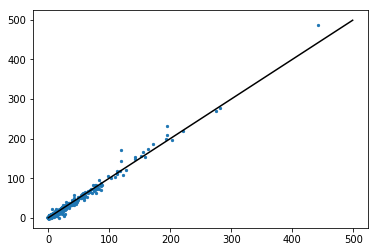

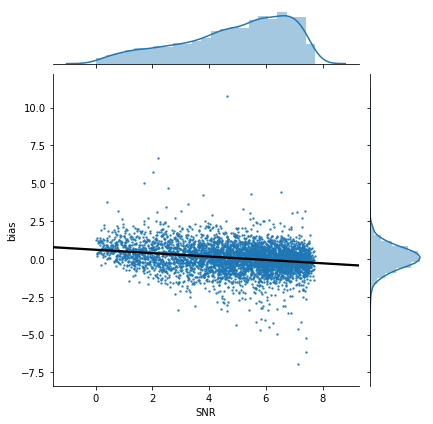

In [165]:
plt.scatter(y_te,y_te_pred_nn,s=5)
plt.plot(np.arange(500),np.arange(500),color='black')

bias_plot(y_te, y_te_pred_nn, df_OCU_te)
print('r2: ',r2_score(y_te,y_te_pred_nn))

## Linear Regression on Filtered Second Derivative set

In [168]:
lr = LinearRegression()
lr.fit(x_tr_der_filtered,y_tr)
y_te_pred_lin_der_filtered = lr.predict(x_te_der_filtered)


r2:  0.977279781910203


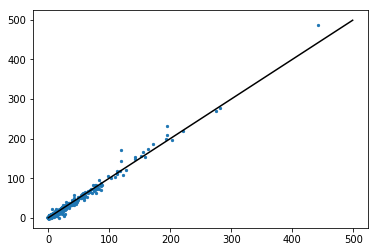

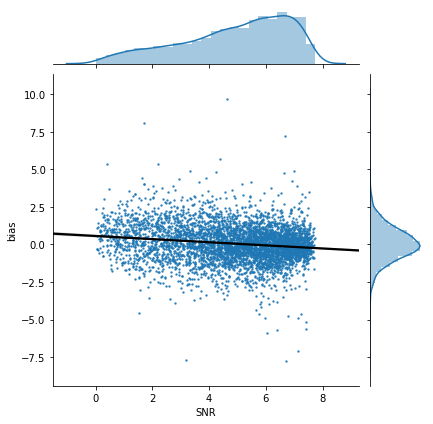

In [170]:
plt.scatter(y_te,y_te_pred_nn,s=5)
plt.plot(np.arange(500),np.arange(500),color='black')

bias_plot(y_te, y_te_pred_lin_der_filtered, df_OCU_te)
print('r2: ',r2_score(y_te,y_te_pred_lin_der_filtered))

# Bias Analysis


In [172]:
# Bias 
SNR_te = y_te/df_OCU_te

#NN
bias_nn = (y_te_pred_nn - y_te)/df_OCU_te

#Linear Filtered 2nd Derivative
bias_ridge = (y_te_pred_lin_der_filtered - y_te)/df_OCU_te


In [174]:
# Compute bias metric

print('bias nn: ',compute_bias_metric_noplot(bias_nn,SNR_te))

print('bias LR on filtered 2nd derivative: ', compute_bias_metric_noplot(bias_ridge,SNR_te))

bias nn:  0.3239057622967204
bias LR on filtered 2nd derivative:  0.3612114285486146


# Reduced Sample Size
Here we will test the performance with 1000 samples based on the analysis done before. We will use NN

In [176]:
sample_size = 1000
#shuffle indices
np.random.seed(7)
num_row = np.shape(pca_tr)[0]
indices = np.random.permutation(np.arange(num_row))

nn = MLPRegressor(hidden_layer_sizes=(600,),alpha=1e-5,batch_size=200,max_iter=600)
nn.fit(pca_tr[indices[:sample_size],:],y_tr[indices[:sample_size]])
print('NN, 600 layers, alpha=1e-5,sample size =%d'% sample_size)

NN, 600 layers, alpha=1e-5,sample size =1000


In [177]:
y_te_pred_nn = nn.predict(pca_te)


0.9745889301644859

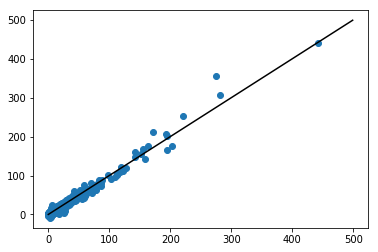

In [178]:
plt.scatter(y_te,y_te_pred_nn)
plt.plot(np.arange(500),np.arange(500),color='black')
r2_score(y_te,y_te_pred_nn)

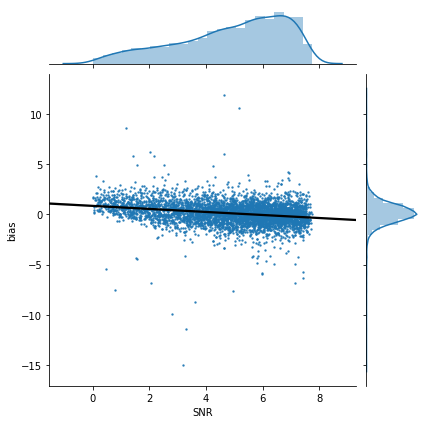

In [179]:
#Bias plot
bias_plot(y_te, y_te_pred_nn, df_OCU_te)

We see that the proposed model is robust and gives good estimates over a range of sample sizes. It would be nice to analyse the effect of sites on the prediction, and be able to pin down the minimum number of sites. I guess that is the next step